2018 Oct 9<br>
Since I'm getting a little short on time for DPS, I'm going to do a quick once-through of the planned full analysis using the Levenberg-Marquardt approach, with simplified error estimates. Later, I'll go back through with the MCMC analysis to clean up uncertainty estimates.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from scipy.signal import lombscargle

from lightkurve import KeplerLightCurveFile
from PyAstronomy.modelSuite.XTran.forTrans import MandelAgolLC

from transit_utils import bindata, transit_duration, supersample_time
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

import time as tm

import dill

K76 = Kepler76_params()

In [2]:
num_period = 2
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

158.5868291130012


In [3]:
def fit_transit(time, baseline, a, T0, p, b, supersample_factor=10, exp_time=30./60./24.):
    params = K76.saved_params.copy()

    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = params['per']
    ma['a'] = a
    ma['T0'] = T0
    ma['p'] = p
    ma['i'] = np.arccos(b/a)*180./np.pi
    ma["linLimb"] = params["linLimb"]
    ma["quadLimb"] = params["quadLimb"]
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

[-4.34593427e-05  5.09154691e+00  6.84990158e-01  8.48417473e-02
  9.08334341e-01]
[4.61826133e-06 5.01485256e-02 2.39761774e-05 4.94852935e-04
 2.63570610e-03]


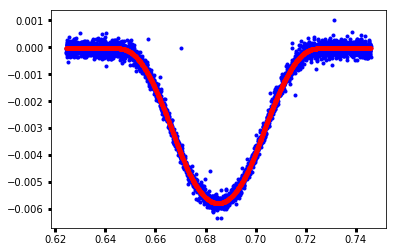

In [4]:
# Fit folded transit
bounds = ([-1000e-6, 2., K76.saved_params['T0']*0.95, 0., -1],
          [1000e-6, 10., K76.saved_params['T0']*1.05, 0.2, 1])

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
err = unbinned_noise*np.ones_like(time)

initial_guess = [0., K76.saved_params['a'], K76.saved_params['T0'], K76.saved_params['p'], K76.saved_params['b']]
transit_popt, transit_pcov = curve_fit(fit_transit, time, data, sigma=err, p0=initial_guess, bounds=bounds)

transit_uncertainties = np.sqrt(transit_pcov.diagonal())

print(transit_popt)
print(transit_uncertainties)

plt.plot(time, data, 'b.')
plt.plot(time, fit_transit(time, *transit_popt), 'r.')

In [5]:
def fit_transit_midtime(time, baseline, T0, 
                        transit_params=transit_popt, supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = params['per']
    ma['a'] = transit_params[1]
    ma['T0'] = T0
    ma['p'] = transit_params[3]
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = params["linLimb"]
    ma["quadLimb"] = params["quadLimb"]
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

<ErrorbarContainer object of 3 artists>

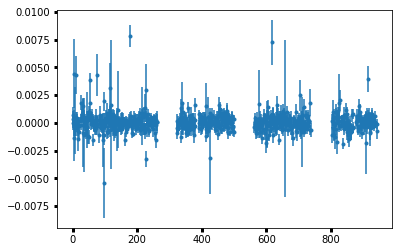

In [6]:
# Fitting transit ephemeris
mn = np.min(filtered_time)
mx = np.min(filtered_time) + K76.saved_params['per']

current_transit_num = 0
transit_nums = []
mid_transit_times = np.array([])
mid_transit_times_err = np.array([])
while(mn <= np.max(filtered_time) - K76.saved_params['per']):
#while(mn < np.min(filtered_time) + 2.*K76.saved_params['per']):
    
    ind = (filtered_time >= mn) & (filtered_time < mx)
    unfolded_time = filtered_time[ind]
    time = folded_time[ind]
    data = filtered_flux[ind]
    err = unbinned_noise*np.ones_like(time)
    
    transit_ind = transit_indices(time, 2.*K76.dur, K76.saved_params['T0'])
    # At least three points in transit
    if(time[transit_ind].size >= 3):

        bounds = ([-1000e-6, K76.saved_params['T0']*0.95],
          [1000e-6, K76.saved_params['T0']*1.05])

        initial_guess = [0., K76.saved_params['T0']]
        single_transit_popt, single_transit_pcov = curve_fit(fit_transit_midtime, time, data, sigma=err,
                                                             p0=initial_guess, bounds=bounds)
        single_transit_uncertainties = np.sqrt(single_transit_pcov.diagonal())

        if(single_transit_uncertainties[1] > 0):
            transit_nums.append(current_transit_num)
            mid_transit_times = np.append(mid_transit_times, single_transit_popt[1] +\
                                          np.floor(np.min(filtered_time[ind])/K76.saved_params['per'])*\
                                          K76.saved_params['per'])
            mid_transit_times_err = np.append(mid_transit_times_err, single_transit_uncertainties[1])
            
#             plt.plot(filtered_time[ind], data, 'b.')
#             plt.plot(filtered_time[ind], fit_transit_midtime(time, *single_transit_popt), 'r.', alpha=0.5)
#             plt.axvline(single_transit_popt[1] +\
#                         np.floor(np.min(filtered_time[ind])/K76.saved_params['per'])*K76.saved_params['per'])

    current_transit_num += 1
    mn += K76.saved_params['per']
    mx += K76.saved_params['per']
    
plt.errorbar(transit_nums, mid_transit_times - K76.saved_params['per']*np.array(transit_nums) - mid_transit_times[0], 
             mid_transit_times_err, marker='.', ls='')

1.544928932, 132.004132390
[9.07993116e-08 4.52744462e-05]
1.544928750
928.961857793393


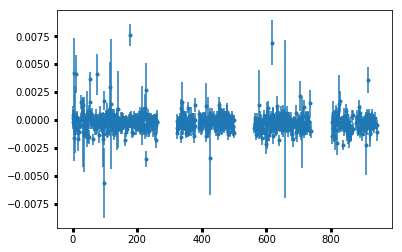

In [7]:
# Fit new period
def fit_line(x, m, b):
    return m*x + b

bounds = ([K76.saved_params['per']*0.95, np.min(filtered_time) - K76.saved_params['per']],
          [K76.saved_params['per']*1.05, np.min(filtered_time) + K76.saved_params['per']])
initial_guess = [K76.saved_params['per'], np.min(filtered_time)]
ephemeris_popt, ephemeris_pcov = curve_fit(fit_line, transit_nums, mid_transit_times, sigma=mid_transit_times_err, 
                                          p0=initial_guess, bounds=bounds)
ephemeris_uncertainties = np.sqrt(ephemeris_pcov.diagonal())

print("%11.9f, %11.9f" % (ephemeris_popt[0], ephemeris_popt[1]))
print(ephemeris_uncertainties)
print("%11.9f" % K76.saved_params['per'])

expected_mid_transit_times = np.array(transit_nums)*K76.saved_params['per']
O_minus_C = mid_transit_times - expected_mid_transit_times - np.min(filtered_time)

plt.errorbar(transit_nums, mid_transit_times - np.polyval(ephemeris_popt, transit_nums), mid_transit_times_err, 
             marker='.', ls='')

# And finally check for any periodic signals -
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
nout = 10000
max_freq = 2./np.min(mid_transit_times[1:] - mid_transit_times[0:-1])
min_freq = 1./(np.max(mid_transit_times) - np.min(mid_transit_times[0:-1]))
f = np.linspace(min_freq, max_freq, nout)
pgram = lombscargle(mid_transit_times, mid_transit_times - np.polyval(ephemeris_popt, transit_nums), f)

# No peak (except for peak for whole time span) is more than barely above the other peaks, suggesting no periodicity
#plt.semilogx(1./f, pgram)
print((1./f)[np.argmax(pgram)])
# Faigler's period - 1.54492875 ± 0.00000027 days - Within about 1-sigma

[-4.34593427e-05  5.09154691e+00  6.84990158e-01  8.48417473e-02
  9.08334341e-01]
[4.61826133e-06 5.01485256e-02 2.39761774e-05 4.94852935e-04
 2.63570610e-03]
[-4.33979599e-05  5.09104404e+00  6.84990186e-01  8.48421841e-02
  9.08344614e-01]
[4.61796166e-06 5.00778944e-02 2.39774727e-05 4.94083918e-04
 2.63166388e-03]


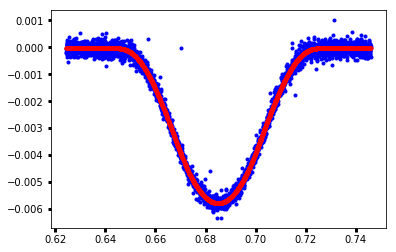

In [8]:
# Adjust fit parameters using new period
def fit_transit_with_new_period(time, baseline, a, T0, p, b, supersample_factor=10, exp_time=30./60./24.):
    params = K76.saved_params.copy()

    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = ephemeris_popt[0]
    ma['a'] = a
    ma['T0'] = T0
    ma['p'] = p
    ma['i'] = np.arccos(b/a)*180./np.pi
    ma["linLimb"] = params["linLimb"]
    ma["quadLimb"] = params["quadLimb"]
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

# Fit folded transit
bounds = ([-1000e-6, 2., K76.saved_params['T0']*0.95, 0., -1],
          [1000e-6, 10., K76.saved_params['T0']*1.05, 0.2, 1])

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
err = unbinned_noise*np.ones_like(time)

initial_guess = [0., K76.saved_params['a'], K76.saved_params['T0'], K76.saved_params['p'], K76.saved_params['b']]
new_transit_popt, new_transit_pcov = curve_fit(fit_transit_with_new_period, time, data, sigma=err, 
                                       p0=initial_guess, bounds=bounds)

new_transit_uncertainties = np.sqrt(new_transit_pcov.diagonal())

print(transit_popt)
print(transit_uncertainties)
print(new_transit_popt)
print(new_transit_uncertainties)

plt.plot(time, data, 'b.')
plt.plot(time, fit_transit(time, *new_transit_popt), 'r.')

In [9]:
new_dur = transit_duration({'per': ephemeris_popt[0], 'p': new_transit_popt[3], 'b': new_transit_popt[4], 
                            'a': new_transit_popt[1]})

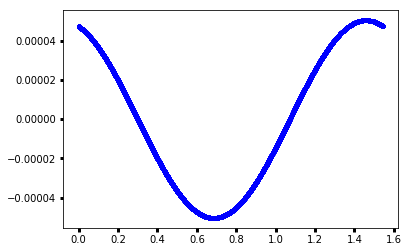

In [10]:
def fit_eclipse_and_BEER_signals(time, baseline, eclipse_depth, Aellip, Abeam, Aplanet, phase_shift,
                        transit_params=new_transit_popt, supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = ephemeris_popt[0]
    ma['a'] = transit_params[1]
    ma['T0'] = (ephemeris_popt[1] % ephemeris_popt[0]) + 0.5*params['per']
    ma['p'] = np.sqrt(np.abs(eclipse_depth))*np.sign(eclipse_depth)
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = 0.
    ma["quadLimb"] = 0.
    
#    transit_supersample = np.zeros_like(time_supersample)
    transit_supersample = ma.evaluate(time_supersample) - 1.
    
#     BEER_signals = np.zeros_like(time_supersample)
    params['per'] = ephemeris_popt[0]
    params['baseline'] = 0.
    params['Aellip'] = Aellip
    params['Abeam'] = Abeam
    params['Aplanet'] = Aplanet
    params['phase_shift'] = phase_shift
    params['a'] = transit_params[1]
    params['T0'] = (ephemeris_popt[1] % ephemeris_popt[0])
    params['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    
    cur_BC = BEER_curve(time_supersample, params, supersample_factor=1)
    BEER_signals = cur_BC.all_signals()
    
    signal = BEER_signals + transit_supersample + baseline
    
    return np.mean(signal.reshape(-1, supersample_factor), axis=1)

initial_guess = [0., 0., 0., 0., 
                 K76.saved_params['Aplanet'], 0.]
plt.plot(folded_time, fit_eclipse_and_BEER_signals(folded_time, *initial_guess), 'b.')

[2.68792635e-05 8.66185641e-05 1.21326644e-05 1.20310428e-05
 4.98374454e-05 2.62845537e-03]
[8.26736578e-07 5.42850202e-06 1.26310871e-06 1.03508395e-06
 1.26016551e-06 3.24371162e-10]


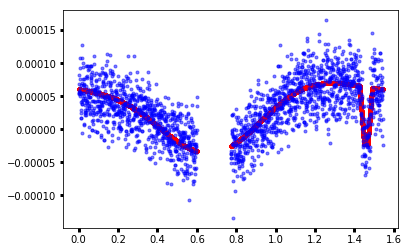

In [11]:
# 2018 Oct 15 - Fit folded BEER and eclipse
out_of_transit_ind = ~transit_indices(folded_time, 3.*new_dur, (ephemeris_popt[1] % ephemeris_popt[0]))
time = folded_time[out_of_transit_ind]
data = filtered_flux[out_of_transit_ind]
err = unbinned_noise*np.ones_like(time)

bounds = ([-1000e-6, -1000e-6, -500e-6, -500e-6, -500e-6, -1], 
          [1000e-6, 1000e-6, 500e-6, 500e-6, 500e-6, 1])
initial_guess = [0., 100e-6, K76.saved_params['Aellip'], K76.saved_params['Abeam'], 
                 K76.saved_params['Aplanet'], 0.]

new_BEER_popt, new_BEER_pcov = curve_fit(fit_eclipse_and_BEER_signals, time, data, sigma=err, 
                       p0=initial_guess, bounds=bounds)
new_BEER_uncertainties = np.sqrt(new_BEER_pcov.diagonal())

# Rescale uncertainties
redchisq = redchisqg(data, fit_eclipse_and_BEER_signals(time, *new_BEER_popt), 2, err)
new_BEER_uncertainties *= np.sqrt(redchisq)

print(new_BEER_popt)
print(new_BEER_uncertainties)

binned_time, binned_data, binned_err = bindata(time, data, 1./60./24.)

plt.plot(time, fit_eclipse_and_BEER_signals(time, *new_BEER_popt), 'r.')
plt.plot(binned_time, binned_data, 'b.', alpha=0.5)

In [12]:
# Fitting eclipses and BEER signals together
def fit_eclipse_and_BEER_signals_fixed_beam(time, baseline, eclipse_depth, Aellip, Aplanet, phase_shift,
                                                  BEER_params=new_BEER_popt, transit_params=new_transit_popt, 
                                                  supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = ephemeris_popt[0]
    ma['a'] = transit_params[1]
    ma['T0'] = (ephemeris_popt[1] % ephemeris_popt[0]) + 0.5*params['per']
    ma['p'] = np.sqrt(np.abs(eclipse_depth))*np.sign(eclipse_depth)
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = 0.
    ma["quadLimb"] = 0.
    
#    transit_supersample = np.zeros_like(time_supersample)
    transit_supersample = ma.evaluate(time_supersample) - 1.
    
#     BEER_signals = np.zeros_like(time_supersample)
    params['per'] = ephemeris_popt[0]
    params['baseline'] = 0.
    params['Aellip'] = Aellip
    params['Abeam'] = BEER_params[3]
    params['Aplanet'] = Aplanet
    params['phase_shift'] = phase_shift
    params['a'] = transit_params[1]
    params['T0'] = (ephemeris_popt[1] % ephemeris_popt[0])
    params['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    
    cur_BC = BEER_curve(time_supersample, params, supersample_factor=1)
    BEER_signals = cur_BC.all_signals()
    
    signal = BEER_signals + transit_supersample + baseline
    
    return np.mean(signal.reshape(-1, supersample_factor), axis=1)

def fit_eclipse_and_BEER_signals_fixed_beam_ellip(time, baseline, eclipse_depth, Aplanet, phase_shift,
                                                  BEER_params=new_BEER_popt, transit_params=new_transit_popt, 
                                                  supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = ephemeris_popt[0]
    ma['a'] = transit_params[1]
    ma['T0'] = (ephemeris_popt[1] % ephemeris_popt[0]) + 0.5*params['per']
    ma['p'] = np.sqrt(np.abs(eclipse_depth))*np.sign(eclipse_depth)
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = 0.
    ma["quadLimb"] = 0.
    
#    transit_supersample = np.zeros_like(time_supersample)
    transit_supersample = ma.evaluate(time_supersample) - 1.
    
#     BEER_signals = np.zeros_like(time_supersample)
    params['per'] = ephemeris_popt[0]
    params['baseline'] = 0.
    params['Aellip'] = BEER_params[2]
    params['Abeam'] = BEER_params[3]
    params['Aplanet'] = Aplanet
    params['phase_shift'] = phase_shift
    params['a'] = transit_params[1]
    params['T0'] = (ephemeris_popt[1] % ephemeris_popt[0])
    params['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    
    cur_BC = BEER_curve(time_supersample, params, supersample_factor=1)
    BEER_signals = cur_BC.all_signals()
    
    signal = BEER_signals + transit_supersample + baseline
    
    return np.mean(signal.reshape(-1, supersample_factor), axis=1)

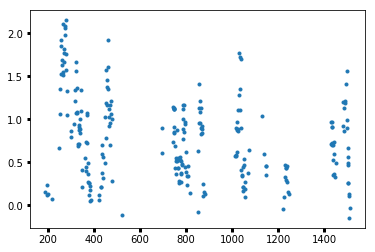

In [47]:
#baseline, eclipse_depth, Aellip, Abeam, Aplanet, phase_shift

num_periods_to_fold = 20.

# orbit_times = {}
# best_fit_params = {}
# best_fit_params_uncertainties = {}

orbit_times[num_periods_to_fold] = [0.]

bounds = ([-1000e-6, -1000e-6, -500e-6,-500e-6, -1], 
          [1000e-6, 1000e-6, 500e-6, 500e-6, 1])
initial_guess = [0., 100e-6, K76.saved_params['Aellip'], K76.saved_params['Aplanet'], 0.]
best_fit_params[num_periods_to_fold] = initial_guess
best_fit_params_uncertainties[num_periods_to_fold] = initial_guess

mn = np.min(filtered_time)
mx = np.min(filtered_time) + num_periods_to_fold*ephemeris_popt[0]

while(mx <= np.max(filtered_time) - num_periods_to_fold*ephemeris_popt[0]):
# while(mn <= np.min(filtered_time) + ephemeris_popt[0]):
    
    # Next orbit's data, minus the transit portion    
    ind = ((filtered_time >= mn) & (filtered_time < mx))
    unfolded_time = filtered_time[ind]
    time = folded_time[ind]
    data = filtered_flux[ind]
    err = unbinned_noise*np.ones_like(time)
    
    out_of_transit_ind = ~transit_indices(time, 3.*K76.dur, (ephemeris_popt[1] % ephemeris_popt[0]))
    unfolded_time = unfolded_time[out_of_transit_ind]
    time = time[out_of_transit_ind]
    data = data[out_of_transit_ind]
    err = err[out_of_transit_ind]
    
    if(time.size >= np.floor(num_periods_to_fold/2*ephemeris_popt[0]/(30./60./24.))):
    # 2018 Oct 16 - The gaps in the time series seem to coincide with jumps in the signals - Not good!
    #   To try to reduce the effect of the gaps, I'm going to require that the window NOT extend 
    #   into a gap.
    
#     del_time = 0.
#     if(time.size > 0):
#         del_time = (np.max(unfolded_time) - np.min(unfolded_time))
#     if(np.abs(del_time - num_periods_to_fold*ephemeris_popt[0]) <= 5.*(30./60./24.)):

        cur_orbit_time = np.mean(unfolded_time)
        popt, pcov = curve_fit(fit_eclipse_and_BEER_signals_fixed_beam, time, data, sigma=err, 
                               p0=initial_guess, bounds=bounds)
        uncertainties = np.sqrt(pcov.diagonal())

        # Rescale uncertainties
        redchisq = redchisqg(data, fit_eclipse_and_BEER_signals_fixed_beam(time, *popt), 2, err)

        orbit_times[num_periods_to_fold] =\
            np.append(orbit_times[num_periods_to_fold], cur_orbit_time)
        best_fit_params[num_periods_to_fold] = np.vstack((best_fit_params[num_periods_to_fold], popt))
        best_fit_params_uncertainties[num_periods_to_fold] =\
            np.vstack((best_fit_params_uncertainties[num_periods_to_fold], 
                      uncertainties*np.sqrt(redchisq)))
#         if(popt[1]/uncertainties[1] > 6.):
#        if((popt[1] > 245e-6) & (popt[1]/uncertainties[1] > 1.)):
#         if(popt[1] < 33e-6):
#             fig = plt.figure()
            
#             binned_time, binned_data, binned_err = bindata(time, data, 10./60./24.)
#            plt.plot(binned_time, binned_data, 'k.')
#             plt.plot(time, data, 'b.')
#             plt.plot(time, fit_eclipse_and_BEER_signals_fixed_beam(time, *popt), 'r.')
            
#             print(redchisq)
#             print(popt[1], uncertainties[1], popt[1]/uncertainties[1])
#             plt.axhline(popt[0] - popt[1] + popt[3])
#             break
            
    mn += ephemeris_popt[0]
    mx += ephemeris_popt[0]
  
    # baseline, eclipse_depth, Aellip, Aplanet, phase_shift

#which_param = 1
# x = orbit_times[10][1:]
# y = best_fit_params[10][1:,which_param]
# yerr = best_fit_params_uncertainties[10][1:,which_param]
# ind = (np.abs(y/yerr) > 0.)
# # plt.errorbar(x[ind], y[ind]*1e6, yerr[ind]*1e6, marker='.', ls='')
# plt.plot(x[ind], (y[ind] - np.mean(y[ind]))/yerr[ind], marker='.', ls='')
    
which_param = 1
x = orbit_times[20][1:]
y = best_fit_params[20][1:,which_param]
yerr = best_fit_params_uncertainties[20][1:,which_param]
ind = (np.abs(y/yerr) > 3)
plt.plot(x[ind], (y[ind] - np.mean(y))/yerr[ind], marker='.', ls='')
# plt.ylim([-4, 4])

#plt.plot(best_fit_params[20][1:,1][ind]*1e6, best_fit_params[20][1:,3][ind]*1e6, marker='.', ls='')

#plt.plot(best_fit_params[20][1:,3][ind], best_fit_params[20][1:,4][ind], marker='.', ls='')

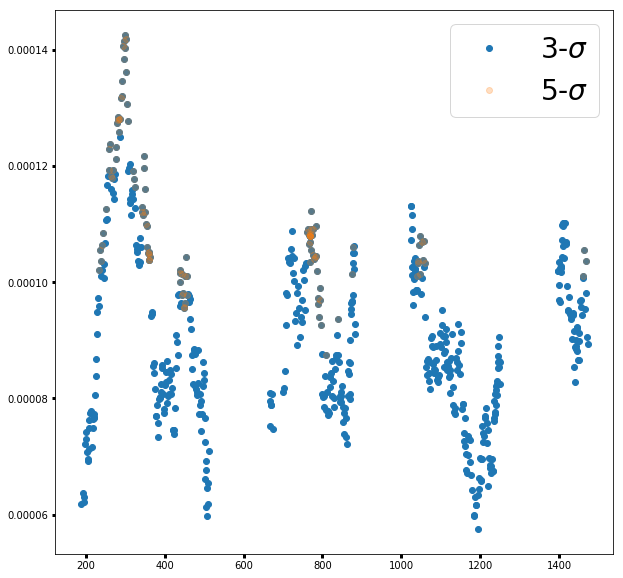

In [176]:
fig = plt.figure(figsize=(10,10))

num_periods_to_fold = 50

ind = (best_fit_params[num_periods_to_fold][1:,1]/best_fit_params_uncertainties[num_periods_to_fold][1:,1] > 3.)
x = orbit_times[num_periods_to_fold][1:]
y = best_fit_params[num_periods_to_fold][1:,1]
yerr = best_fit_params_uncertainties[num_periods_to_fold][1:,1]
plt.plot(x[ind], y[ind], marker='o', ls='', label="3-$\\sigma$")
#plt.errorbar(x[ind], y[ind]*1e6, yerr[ind]*1e6, color='k', marker='.', ls='')

ind = (best_fit_params[num_periods_to_fold][1:,1]/best_fit_params_uncertainties[num_periods_to_fold][1:,1] > 5.)
x = orbit_times[num_periods_to_fold][1:]
y = best_fit_params[num_periods_to_fold][1:,1]
yerr = best_fit_params_uncertainties[num_periods_to_fold][1:,1]
plt.plot(x[ind], y[ind], marker='o', ls='', alpha=0.25, label="5-$\\sigma$")
#plt.errorbar(x[ind], y[ind]*1e6, yerr[ind]*1e6, marker='.', ls='', alpha=0.5)

plt.legend(fontsize=28)
fig.savefig('Eclipse-Variability_stacking-50-orbs.png', dpi=500, bbox_inches='tight')

46


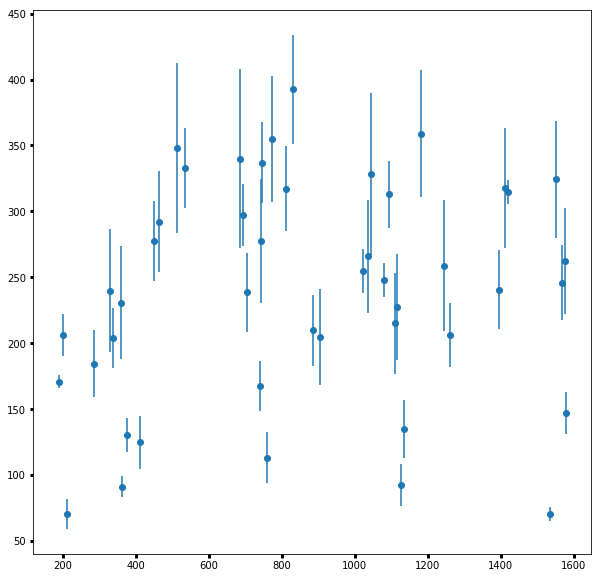

In [86]:
plt.figure(figsize=(10,10))

for cur_key in [1]:
    ind = eclipse_depths[cur_key]/eclipse_depths_uncertainties[cur_key] > 5.
    med = np.median(eclipse_depths[cur_key][ind])
    plt.errorbar(eclipse_times[cur_key][ind], eclipse_depths[cur_key][ind]*1e6, 
                 eclipse_depths_uncertainties[cur_key][ind]*1e6, marker='o', ls='')
#    plt.plot(eclipse_times[cur_key][ind], eclipse_depths[cur_key][ind])
    
    print(eclipse_times[cur_key][ind].size)
    
#dill.dump_session("Analyzing_Kepler76b_with_LM_2018Oct11_5-06p.pkl")

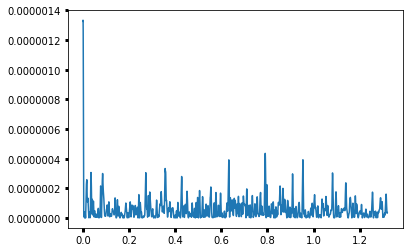

In [74]:
# And finally check for any periodic signals -
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html

cur_key = 1.
ind = eclipse_depths[cur_key]/eclipse_depths_uncertainties[cur_key] > 5.

nout = 10000
max_freq = 2./np.min(eclipse_times[1][ind][1:] - eclipse_times[1][ind][0:-1])
min_freq = 1./(np.max(eclipse_times[1][ind]) - np.min(eclipse_times[1][ind][0:-1]))
f = np.linspace(min_freq, max_freq, nout)
pgram = lombscargle(eclipse_times[1][ind], eclipse_depths[cur_key][ind], f)
# No peak (except for peak for whole time span) is more than barely above the other peaks, suggesting no periodicity
plt.plot(f, pgram)

In [3]:
# 2018 Oct 12 - Reload previous results
dill.load_session("Analyzing_Kepler76b_with_LM_2018Oct11_5-06p.pkl")

TypeError: cannot create weak reference to 'NoneType' object

[ 2.79791262e-05  1.60345217e-05  7.08068469e-06  4.65910137e-05
 -1.53652806e-02]
[2.48885784e-04 3.84395223e-04 6.14045712e+04 5.91897389e+03
 2.08781299e+08]


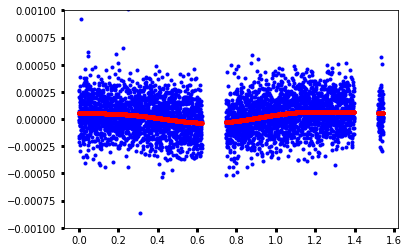

In [68]:
# Fit the planetary phase curves and check whether it is consistent with the eclipse depths

# fit_BEER_signals(cur_time, baseline, Aellip, Abeam, Aplanet, phase_shift)

bounds = ([-500e-6, -500e-6, -500e-6, -500e-6, -1],
          [500e-6, 500e-6, 500e-6, 500e-6, 1])
initial_guess = [0., K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['Aplanet'], 
                 K76.saved_params['phase_shift']]


out_of_transit_ind = ~(transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0']) | 
                       transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'] + 0.5*K76.saved_params['per']))

filtered_time_all_BEER = filtered_time[out_of_transit_ind]
folded_time_all_BEER = folded_time[out_of_transit_ind]
filtered_flux_all_BEER = filtered_flux[out_of_transit_ind]

num_periods_to_fold = 75.

mn = np.min(filtered_time)
mx = np.min(filtered_time) + num_periods_to_fold*ephemeris_popt[0]

orbit_times = {}
BEER_params = {}
BEER_params_uncertainties = {}

orbit_times[num_periods_to_fold] = np.array([])
BEER_params[num_periods_to_fold] = initial_guess
BEER_params_uncertainties[num_periods_to_fold] = initial_guess
#while(mx <= np.max(filtered_time_all_BEER) - num_periods_to_fold*K76.saved_params['per']):
while(mn < np.min(filtered_time) + 2.*K76.saved_params['per']):
    
    try:
        ind = (filtered_time_all_BEER >= mn) & (filtered_time_all_BEER < mx)
        time = folded_time_all_BEER[ind]
        data = filtered_flux_all_BEER[ind]
        err = unbinned_noise*np.ones_like(time)
        
        BEER_popt, BEER_pcov = curve_fit(fit_BEER_signals, time, data, sigma=err, 
                                         p0=initial_guess, bounds=bounds)
        BEER_uncertainties = np.sqrt(BEER_pcov.diagonal())

        # Rescale uncertainties
        redchisq = redchisqg(data, fit_BEER_signals(time, *BEER_popt), 5, err)
        print(BEER_popt)
        print(BEER_uncertainties)
        
        # If chi-squared is weird...
        if((~np.isfinite(redchisq)) | (redchisq < 0.) | (np.isnan(redchisq))):
            pass
        
        orbit_times[num_periods_to_fold] =\
            np.append(orbit_times[num_periods_to_fold], np.mean(filtered_time_all_BEER[ind]))
        BEER_params[num_periods_to_fold] = np.vstack((BEER_params[num_periods_to_fold], BEER_popt))
        BEER_params_uncertainties[num_periods_to_fold] =\
            np.vstack((BEER_params_uncertainties[num_periods_to_fold], BEER_uncertainties*np.sqrt(redchisq)))

        plt.plot(folded_time_all_BEER[ind], filtered_flux_all_BEER[ind], 'b.')
        plt.plot(folded_time_all_BEER[ind], fit_BEER_signals(folded_time_all_BEER[ind], *BEER_popt), 'r.')
        plt.ylim([-0.001, 0.001])
        break

    except:
        pass
    
    mn += K76.saved_params['per']
    mx += K76.saved_params['per']

#print(BEER_params_uncertainties[num_periods_to_fold][1:,:])

# Aplanet = BEER_params[num_periods_to_fold][1:,3]
# Aplanet_err = BEER_params_uncertainties[num_periods_to_fold][1:,:]
# ind = (~np.isnan(Aplanet_err))
# print(Aplanet_err[ind])

# plt.plot(orbit_times[num_periods_to_fold][ind], Aplanet[ind], 'b.')